In [28]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [29]:
# Dataset conatains the following files:
# data.csv
# data_by_artist.csv
# data_by_genres.csv
# data_by_year.csv
# data_w_genres.csv

import kagglehub

# Download latest version
path = kagglehub.dataset_download("vatsalmavani/spotify-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'spotify-dataset' dataset.
Path to dataset files: /kaggle/input/spotify-dataset


In [30]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path where you saved the file in Google Drive
drive_path = '/content/drive/My Drive/Colab Notebooks/musix'


# Load the CSV file into a pandas DataFrame
spotify_df = pd.read_csv(drive_path + '/spotify.csv')

# Display the first few rows to verify
print(f"Successfully loaded 'spotify.csv' from Google Drive. Shape: {spotify_df.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully loaded 'spotify.csv' from Google Drive. Shape: (114000, 20)


In [35]:
df_year = pd.read_csv(f"{path}/data/data_by_year.csv")
df_year.head()

,mode,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key
0,1,1921,0.886896,0.418597,260537.166667,0.231815,0.344878,0.205710,-17.048667,0.073662,101.531493,0.379327,0.653333,2
1,1,1922,0.938592,0.482042,165469.746479,0.237815,0.434195,0.240720,-19.275282,0.116655,100.884521,0.535549,0.140845,10
2,1,1923,0.957247,0.577341,177942.362162,0.262406,0.371733,0.227462,-14.129211,0.093949,114.010730,0.625492,5.389189,0
3,1,1924,0.940200,0.549894,191046.707627,0.344347,0.581701,0.235219,-14.231343,0.092089,120.689572,0.663725,0.661017,10
4,1,1925,0.962607,0.573863,184986.924460,0.278594,0.418297,0.237668,-14.146414,0.111918,115.521921,0.621929,2.604317,5


In [36]:
df_tracks = spotify_df.copy()
df_tracks.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [33]:
AUDIO_FEATURES = [
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "speechiness",
    "tempo",
    "valence",
    "duration_ms",
    "mode",
    "key"
]

In [34]:
def ensure_columns(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

def standardize_and_cluster(data: pd.DataFrame, feature_cols, n_clusters: int, random_state: int = 42):
    """
    Scales numeric features and runs KMeans.
    Returns: (data_with_cluster, scaled_matrix, scaler, kmeans)
    """
    X = data[feature_cols].astype(float).values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init="auto")
    labels = kmeans.fit_predict(X_scaled)

    out = data.copy()
    out["cluster"] = labels
    return out, X_scaled, scaler, kmeans

def pca_plot(X_scaled, labels, title):
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X_scaled)
    plt.figure(figsize=(8,6))
    plt.scatter(X2[:,0], X2[:,1], c=labels, cmap="tab10")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

def print_cluster_summary(df_clustered: pd.DataFrame, feature_cols, id_col: str = None, top_n: int = 12):
    """
    Prints mean feature profile per cluster, plus example members if id_col is provided.
    """
    print("\n=== Cluster sizes ===")
    print(df_clustered["cluster"].value_counts().sort_index())

    print("\n=== Cluster feature means ===")
    summary = df_clustered.groupby("cluster")[feature_cols].mean().round(4)
    display(summary)

    if id_col is not None:
        print("\n=== Example members per cluster ===")
        for c in sorted(df_clustered["cluster"].unique()):
            members = df_clustered[df_clustered["cluster"] == c][id_col].head(top_n).tolist()
            print(f"\nCluster {c} ({len(df_clustered[df_clustered['cluster']==c])} items):")
            print(members)


In [37]:
ensure_columns(df_tracks, ["track_genre"] + AUDIO_FEATURES)

df_tracks = df_tracks.dropna(subset=["track_genre"] + AUDIO_FEATURES).copy()
df_tracks["track_genre"] = df_tracks["track_genre"].astype(str).str.strip()

genre_df = df_tracks.groupby("track_genre")[AUDIO_FEATURES].mean().reset_index()
print("Genre-level aggregated shape:", genre_df.shape)

Genre-level aggregated shape: (114, 13)


In [38]:
ensure_columns(df_year, ["year"] + AUDIO_FEATURES)

df_year = df_year.dropna(subset=["year"] + AUDIO_FEATURES).copy()
df_year["year"] = df_year["year"].astype(int)


=== Cluster sizes ===
cluster
0    27
1    35
2    17
3    21
Name: count, dtype: int64

=== Cluster feature means ===


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,mode,key
cluster,,,,,,,,,,,,
0,0.8435,0.4779,0.2827,0.2953,0.2113,-14.8968,0.0995,110.0987,0.4877,220633.2551,1.0,1.7037
1,0.2810,0.5779,0.6193,0.0950,0.1940,-8.6789,0.0867,120.7332,0.5161,238749.6317,1.0,4.7714
2,0.8605,0.5590,0.2785,0.3265,0.2274,-14.8423,0.2114,111.4748,0.5824,193882.3176,1.0,6.5882
3,0.3997,0.5259,0.5346,0.1196,0.2125,-11.3624,0.0606,119.4368,0.5752,243825.7537,1.0,2.5714


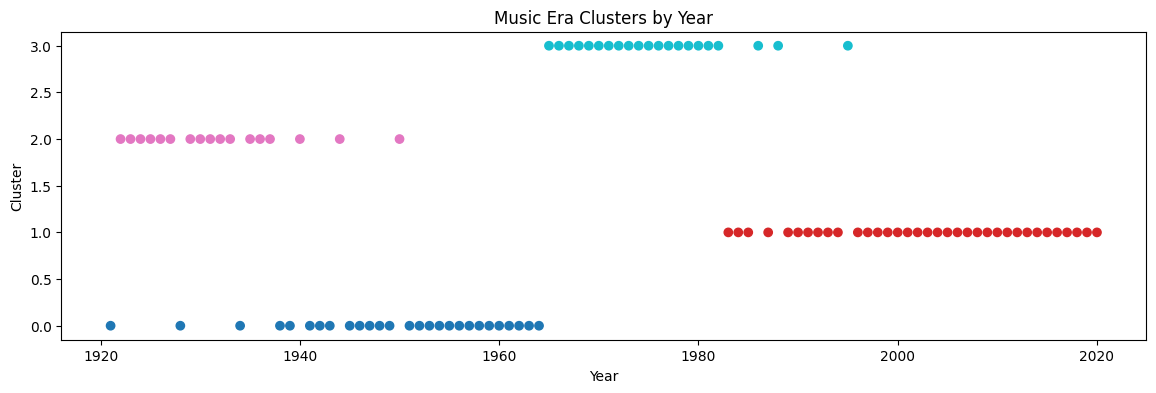

In [39]:
N_CLUSTERS_YEAR = 4  # adjust (3–6 usually good)
year_clustered, Xy_scaled, year_scaler, year_kmeans = standardize_and_cluster(
    df_year, AUDIO_FEATURES, n_clusters=N_CLUSTERS_YEAR
)

print_cluster_summary(year_clustered, AUDIO_FEATURES)

# Timeline plot: year vs cluster
plt.figure(figsize=(14,4))
plt.scatter(year_clustered["year"], year_clustered["cluster"],
            c=year_clustered["cluster"], cmap="tab10")
plt.title("Music Era Clusters by Year")
plt.xlabel("Year")
plt.ylabel("Cluster")
plt.show()

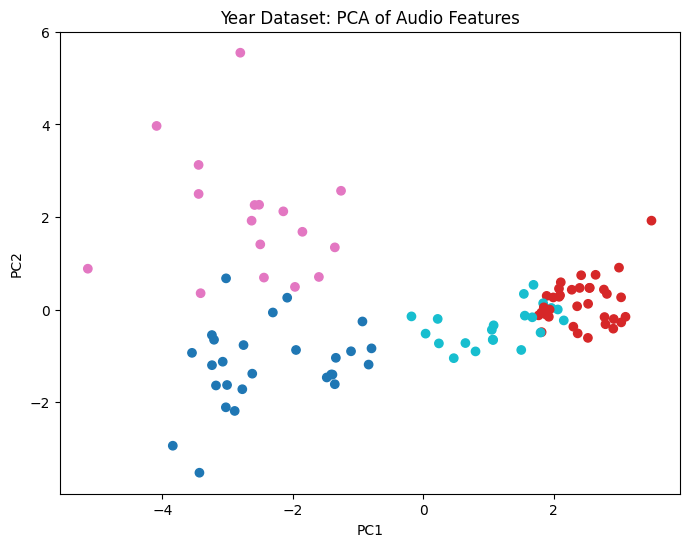

In [40]:
pca_plot(Xy_scaled, year_clustered["cluster"].values, "Year Dataset: PCA of Audio Features")


=== Cluster sizes ===
cluster
0     1
1    25
2    24
3    10
4     1
5    14
6    33
7     6
Name: count, dtype: int64

=== Cluster feature means ===


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,mode,key
cluster,,,,,,,,,,,,
0,0.0087,0.2719,0.9242,0.5385,0.2812,-6.2380,0.1375,119.2299,0.2164,133753.5070,0.6330,5.2070
1,0.4951,0.5520,0.4954,0.0684,0.1906,-9.4720,0.0597,119.3647,0.4788,216077.4430,0.7600,5.1538
2,0.2630,0.5655,0.7299,0.0317,0.2644,-6.6332,0.0668,126.7345,0.6038,224636.3508,0.7037,5.3460
3,0.7474,0.3771,0.3088,0.4955,0.1940,-16.7358,0.0570,108.3834,0.2666,227919.4952,0.6568,4.9569
4,0.7265,0.5772,0.6999,0.0005,0.6617,-10.4575,0.7556,100.9956,0.4548,225430.8630,0.7190,5.0540
5,0.0540,0.4823,0.8464,0.1886,0.2356,-5.5522,0.0911,133.5198,0.3375,250947.4108,0.5650,5.4088
6,0.2298,0.6605,0.6780,0.1105,0.1842,-6.8853,0.1024,120.1796,0.5176,213372.1859,0.5369,5.4245
7,0.1104,0.6794,0.7132,0.5896,0.1626,-9.4214,0.0725,126.6410,0.4064,334864.9587,0.5412,5.5885



=== Example members per cluster ===

Cluster 0 (1 items):
['grindcore']

Cluster 1 (25 items):
['acoustic', 'bluegrass', 'blues', 'british', 'cantopop', 'children', 'chill', 'country', 'folk', 'german', 'gospel', 'honky-tonk', 'indian', 'indie', 'indie-pop', 'jazz', 'mandopop', 'psych-rock', 'rock-n-roll', 'show-tunes']

Cluster 2 (24 items):
['alt-rock', 'brazil', 'forro', 'garage', 'hard-rock', 'j-idol', 'j-pop', 'j-rock', 'mpb', 'pagode', 'party', 'power-pop', 'punk', 'punk-rock', 'r-n-b', 'rock', 'rockabilly', 'salsa', 'samba', 'sertanejo']

Cluster 3 (10 items):
['ambient', 'classical', 'disney', 'guitar', 'iranian', 'new-age', 'opera', 'piano', 'romance', 'sleep']

Cluster 4 (1 items):
['comedy']

Cluster 5 (14 items):
['black-metal', 'death-metal', 'drum-and-bass', 'dub', 'dubstep', 'goth', 'grunge', 'happy', 'hardstyle', 'heavy-metal', 'industrial', 'metal', 'metalcore', 'trance']

Cluster 6 (33 items):
['afrobeat', 'alternative', 'anime', 'club', 'dance', 'dancehall', 'deep-h

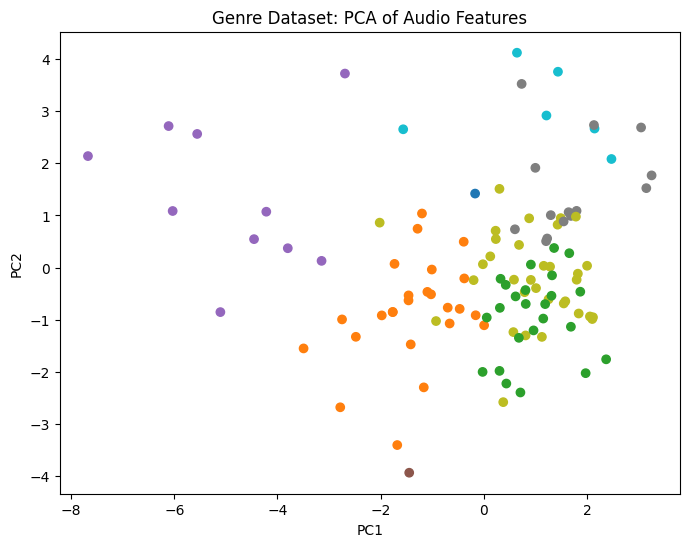

In [41]:
N_CLUSTERS_GENRE = 8  # adjust (6–12 usually good)
genre_clustered, Xg_scaled, genre_scaler, genre_kmeans = standardize_and_cluster(
    genre_df, AUDIO_FEATURES, n_clusters=N_CLUSTERS_GENRE
)

print_cluster_summary(genre_clustered, AUDIO_FEATURES, id_col="track_genre", top_n=20)

# PCA map for genres
pca_plot(Xg_scaled, genre_clustered["cluster"].values, "Genre Dataset: PCA of Audio Features")


In [42]:
subgenre_to_super = dict(zip(genre_clustered["track_genre"], genre_clustered["cluster"]))

# Example lookup:
example = genre_clustered["track_genre"].iloc[0]
print("\nExample mapping:")
print(example, "-> cluster", subgenre_to_super[example])


Example mapping:
acoustic -> cluster 1


In [45]:
# ----------------------------------
# Automatically order clusters by time
# ----------------------------------

# Compute average year per cluster
cluster_order = (
    year_clustered
    .groupby("cluster")["year"]
    .mean()
    .sort_values()
)

print("Cluster order by time:")
print(cluster_order)

# Create chronological era names
ordered_era_names = [
    "Acoustic Foundation Era (1920s–1940s)",
    "Post-War & Rock Expansion (1950s–1960s)",
    "Analog to Electronic Transition (1970s–1990s)",
    "Digital & Streaming Era (2000s–2020s)"
]

# Map clusters chronologically
era_mapping = {
    cluster: ordered_era_names[i]
    for i, cluster in enumerate(cluster_order.index)
}

year_clustered["era_name"] = year_clustered["cluster"].map(era_mapping)

year_clustered[["year","cluster","era_name"]]


Cluster order by time:
cluster
2    1932.000000
0    1949.111111
3    1975.809524
1    2002.514286
Name: year, dtype: float64


,year,cluster,era_name
0,1921,0,Post-War & Rock Expansion (1950s–1960s)
1,1922,2,Acoustic Foundation Era (1920s–1940s)
2,1923,2,Acoustic Foundation Era (1920s–1940s)
3,1924,2,Acoustic Foundation Era (1920s–1940s)
4,1925,2,Acoustic Foundation Era (1920s–1940s)
...,...,...,...
95,2016,1,Digital & Streaming Era (2000s–2020s)
96,2017,1,Digital & Streaming Era (2000s–2020s)
97,2018,1,Digital & Streaming Era (2000s–2020s)
98,2019,1,Digital & Streaming Era (2000s–2020s)


In [ ]:
# Group by era_name to see aggregated statistics
era_summary = year_clustered.groupby("era_name")[AUDIO_FEATURES].mean().round(4)

print("=== Era Summary Statistics ===")
print(f"\nCount of years per era:")
era_counts = year_clustered["era_name"].value_counts()
print(era_counts)
print(f"\nTotal entries: {era_counts.sum()}")

print(f"\n\nAverage audio features per era:")
display(era_summary)

# Optional: Add year range for each era
print("\n\nYear ranges per era:")
year_ranges = year_clustered.groupby("era_name")["year"].agg(["min", "max", "count"])
display(year_ranges)